In [17]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import pytesseract
import cv2
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, LSTM, Flatten, Dense, Reshape, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from torch.optim import AdamW

from transformers import (
    BertTokenizerFast, 
    BertConfig, 
    BertForMaskedLM, 
    AdamW, 
    Trainer, 
    TrainingArguments, 
    DataCollatorForSeq2Seq
)


from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordLevelTrainer

import torch
from torch.utils.data import Dataset

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Start

In [2]:
df=pd.read_csv('dataset/Training/training_labels.csv')

df.head()

,IMAGE,MEDICINE_NAME,GENERIC_NAME
0,0.png,Aceta,Paracetamol
1,1.png,Aceta,Paracetamol
2,2.png,Aceta,Paracetamol
3,3.png,Aceta,Paracetamol
4,4.png,Aceta,Paracetamol


In [3]:
img=cv2.imread('dataset/Training/training_words/69.png',cv2.IMREAD_GRAYSCALE)

img

array([[254, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [254, 252, 244, ..., 252, 254, 255],
       [255, 252, 166, ..., 255, 254, 255],
       [254, 245,  33, ..., 255, 254, 255]], dtype=uint8)

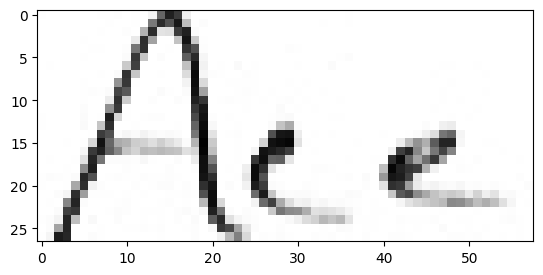

In [4]:
plt.imshow(img,cmap='gray')

# Data Collection

In [5]:
def one_hot_encoded_Y(df):
    return pd.get_dummies(df['MEDICINE_NAME'],dtype=int)

In [6]:
def load_images(image_paths,target_size=(128,32)): # width,height

    imagess=[]

    for path in image_paths:

        img=cv2.imread(path)

        img=cv2.resize(img,target_size)

        img=img.astype('float32')/255.0

        imagess.append(img)

    imagess=np.array(imagess)
    
    imagess=imagess.reshape(imagess.shape[0],32,128,3)

    return imagess

In [7]:
def XY(folder):
    lower=folder.lower()
    
    df=pd.read_csv(f"dataset/{folder}/{lower}_labels.csv")
    
    Y=one_hot_encoded_Y(df)
    
    image_folder=f"dataset/{folder}/{lower}_words/"
    image_paths=[os.path.join(image_folder,filename) for filename in df['IMAGE']]

    X=load_images(image_paths)

    return X,Y

# CRNN model


In [8]:
medicine_names=df['MEDICINE_NAME'].unique()
len(medicine_names) # 78 classes

78

In [9]:
x,y=XY("Training")
xval,yval=XY("Validation")
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2,random_state=12,stratify=y)

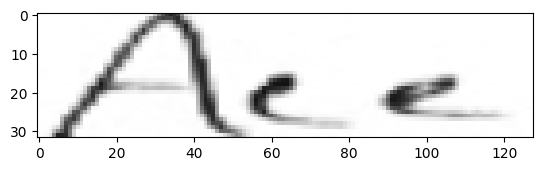

In [13]:
plt.imshow(x[69],cmap='gray')

In [15]:
lambda_reg=0.00001
model=models.Sequential([
    Input(shape=(32, 128, 3)),  

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)), 

    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(lambda_reg)),
    MaxPooling2D(pool_size=(2, 2)), 

    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(lambda_reg)),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Flatten the 3D output to 1D for the Dense layers
    Flatten(),

    Dense(1024, activation='relu', kernel_regularizer=l2(lambda_reg)),
    Dropout(0.55), 

    # Output layer
    Dense(len(medicine_names), activation='softmax', kernel_regularizer=l2(lambda_reg))  
])
model.compile(optimizer=Adam(learning_rate=0.0001,beta_1=0.9, beta_2=0.999),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 128, 32)       896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 64, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 8, 32, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 32, 128)        73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 4, 16, 128)       

In [16]:
history=model.fit(xtrain,
                  ytrain,
                  epochs=20,
                  batch_size=32,
                  validation_data=(xval,yval),
                  callbacks=[EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)])
test_loss,test_acc=model.evaluate(xtest,ytest)
print(f"train's test loss : {test_loss}")
print(f"train's test accuracy : {test_acc}")

Epoch 1/20
78/78 [==============================] - 6s 75ms/step - loss: 4.3900 - accuracy: 0.0104 - val_loss: 4.3607 - val_accuracy: 0.0205
Epoch 2/20
78/78 [==============================] - 6s 71ms/step - loss: 4.3457 - accuracy: 0.0196 - val_loss: 4.2768 - val_accuracy: 0.0526
Epoch 3/20
78/78 [==============================] - 6s 76ms/step - loss: 4.1870 - accuracy: 0.0565 - val_loss: 3.9280 - val_accuracy: 0.1782
Epoch 4/20
78/78 [==============================] - 6s 72ms/step - loss: 3.7499 - accuracy: 0.1470 - val_loss: 3.3248 - val_accuracy: 0.2949
Epoch 5/20
78/78 [==============================] - 6s 72ms/step - loss: 3.1691 - accuracy: 0.2548 - val_loss: 2.9013 - val_accuracy: 0.3372
Epoch 6/20
78/78 [==============================] - 6s 76ms/step - loss: 2.7271 - accuracy: 0.3534 - val_loss: 2.5208 - val_accuracy: 0.4346
Epoch 7/20
78/78 [==============================] - 6s 75ms/step - loss: 2.2747 - accuracy: 0.4367 - val_loss: 2.2925 - val_accuracy: 0.4667
Epoch 8/20
78

# Testing

In [17]:
xtrain,ytrain=XY("Training")
xtest,ytest=XY("Testing")
xval,yval=XY("Validation")

In [18]:
history=model.fit(xtrain,
                  ytrain,
                  epochs=20,
                  batch_size=32,
                  validation_data=(xval,yval),
                  callbacks=[EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)])
test_loss,test_acc=model.evaluate(xtest,ytest)
print(f"test loss : {test_loss}")
print(f"test accuracy : {test_acc}")

Epoch 1/20
98/98 [==============================] - 8s 75ms/step - loss: 0.5127 - accuracy: 0.8901 - val_loss: 1.2479 - val_accuracy: 0.7141
Epoch 2/20
98/98 [==============================] - 7s 73ms/step - loss: 0.3969 - accuracy: 0.9106 - val_loss: 1.2147 - val_accuracy: 0.7218
Epoch 3/20
98/98 [==============================] - 7s 75ms/step - loss: 0.2982 - accuracy: 0.9263 - val_loss: 1.1879 - val_accuracy: 0.7333
Epoch 4/20
98/98 [==============================] - 7s 69ms/step - loss: 0.2327 - accuracy: 0.9433 - val_loss: 1.2196 - val_accuracy: 0.7333
Epoch 5/20
98/98 [==============================] - 7s 69ms/step - loss: 0.1930 - accuracy: 0.9548 - val_loss: 1.1987 - val_accuracy: 0.7359
Epoch 6/20
25/25 [==============================] - 0s 16ms/step - loss: 1.9683 - accuracy: 0.6000
test loss : 1.9682706594467163
test accuracy : 0.6000000238418579


# Saving the model

In [ ]:
model.save('prescription_classification_CNRR.keras')